# **Automated Hyperparameter Tuning**

We'd work on two kinds of Hp_Tuners.

- 1) Heavy Weight Bayesian Tuner (Cold) (THIS NOTEBOOK)

- 2) Lightweight Local Search Tuner (Hot) (Future)

The Heavy Weight Tuner (COLD) is suppposed to be used once, to set the initial parameters in a working spot.

The Lightweight Tuner (HOT) is supposed to be used frequently, to adapt to micro changes in the market properties.

## Loading the Essentials

In [1]:
!pip install ujson optuna nbformat plotly

In [2]:
import ujson
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import plotly.io as pio
pio.renderers.default = "colab"          # or "notebook_connected"

In [3]:
class OrderBookLoader:
    """
    Fast order book loader using ujson and numpy
    Stores snapshots (asks and bids) per timestamp.
    """
    def __init__(self, file_path, max_depth=1, row_start = 0, rows_to_process=None):
        self.file_path = file_path
        self.max_depth = max_depth
        self.row_start = row_start
        self.rows_to_process = rows_to_process
        self.nrows = None
        self.order_books = {}  # {timestamp: {'ask': np.array, 'bid': np.array}}
        self.timestamps = []

    def number_of_rows(self):
        """Return total number of lines in the data file."""
        if(self.nrows):
            return self.nrows
        with open(self.file_path, 'r') as f:
            self.nrows = sum(1 for _ in f)
        return self.nrows

    def read_data(self):
        """
        Read up to `rows_to_process` lines, parse JSON via ujson,
        and store top `max_depth` levels in numpy arrays.
        """
        # Determine how many rows to process
        if self.rows_to_process is None:
            self.rows_to_process = self.number_of_rows()

        with open(self.file_path, 'r') as f:
            for _ in range(self.row_start):
                line = f.readline()
            for _ in tqdm(range(self.rows_to_process), desc="Loading order book "):
                line = f.readline().strip().strip("'")
                if not line:
                    pass
                obj = ujson.loads(line)

                ts = obj['ts']
                a = obj['data']['a'][:self.max_depth]
                b = obj['data']['b'][:self.max_depth]

                # skip incomplete snapshots
                if not a or not b:
                    continue

                # store as numpy arrays of shape (depth, 2): [price, volume]
                self.order_books[ts] = {
                    'ask': np.array(a, dtype=np.float64),
                    'bid': np.array(b, dtype=np.float64)
                }
        self.timestamps = list(self.order_books.keys())
        self.timestamps.sort()

In [4]:
# Class for a single order
class Order:
  def __init__(self, Side, Price, Vol, Timestamp):
    # quote = [price,vol,timestamp]
    self.side = Side
    self.price = Price
    self.vol = Vol
    self.timestamp = Timestamp
    # info at the time of order creation

  def __lt__(self, other): # Defining < operation
    # For price-time priority in the heap (buy orders: max-heap, sell orders: min-heap)
    if self.side == 'buy':
        return self.price > other.price if self.price != other.price else self.timestamp < other.timestamp
    else:
        return self.price < other.price if self.price != other.price else self.timestamp < other.timestamp

In [5]:
import random
import math

class Realistic_INVENTORY:
  #Initialise the inventory
  def __init__(self, Time_limit = 200):
    # Among all our outstanding bid quotes, the highest bid is the most urgent or likely to get filled.
    # Each quote_dict element {'price', 'vol', 'time'}
    self.active_bids = {} # dict: (index, Order)
    self.active_asks = {} # dict: (index, Order)
    self.index = 0
    self.position = 0 # Positive means we're long, negative means we're short
    self.pnl = 0 # Profit if +ve else -ve
    self.tot_spread = 0
    self.base_vol = 0.001
    self.pnl_values = [0]
    self.spread_values = [0]
    self.trade_history = [0]
    self.time_limit = Time_limit # in terms of indices, later modify it to real-time

  def exec_prob(self, time_diff, Lambda=0.1):
    prob = float(1.0 - math.exp(-Lambda * (abs(time_diff)//1000)))
    chance = random.random()
    if chance <= prob:
        return True
    else:
        return False

  def slippage(self, mu=0.0, sigma=0.005):
      gaussian_slippage = abs(np.random.normal(mu, sigma))
      return 1+gaussian_slippage

  def add_quote(self, bid_quote, bid_vol , ask_quote, ask_vol, current_time):
    self.active_bids[self.index] = Order('buy', bid_quote, bid_vol, current_time)
    self.active_asks[self.index] = Order('sell', ask_quote, ask_vol, current_time)
    # self.index += 1 happens in execute function

  def execute(self, bid_traded, best_bid, ask_traded, best_ask, current_time):
    if self.active_bids and bid_traded and (best_bid is not None):
      rem_ids = []
      for idx, bid in list(self.active_bids.items()):
        # if bid.timestamp + self.time_limit < current_time :
        if idx + self.time_limit < self.index :
            rem_ids.append(idx)
        elif (bid.price >= best_bid) and self.exec_prob(current_time-bid.timestamp):
            rem_ids.append(idx)
            self.position += bid.vol/self.base_vol
            self.pnl -= bid.vol * bid.price * self.slippage()
      for id in rem_ids:
        del self.active_bids[id]

    if self.active_asks and ask_traded and (best_ask is not None):
      rem_ids = []
      for idx,ask in list(self.active_asks.items()):
        # if ask.timestamp + self.time_limit < current_time :
        if idx + self.time_limit < self.index :
            rem_ids.append(idx)
        elif (ask.price <= best_ask) and self.exec_prob(current_time-ask.timestamp):
            rem_ids.append(idx)
            self.position -= ask.vol/self.base_vol
            self.pnl += ask.vol * ask.price * self.slippage()
      for id in rem_ids:
        del self.active_asks[id]

    self.index += 1
    self.trade_history.append(self.position)
    self.pnl_values.append(self.pnl)

  def mark_to_market(self, best_bid, best_ask):
    if (best_bid is None) or (best_ask is None):
        return self.pnl

    if self.position >= 0:
        # You're long → you’d sell at bid
        return self.pnl + self.position * best_bid
    else:
        # You're short → you’d buy back at ask
        return self.pnl + self.position * best_ask

  def plot_pnl(self):
    times = range(-1,self.index)
    # --- create two side-by-side sub-plots ---
    fig, (ax_l, ax_r) = plt.subplots(
        nrows=1, ncols=2, figsize=(12, 5), sharex=True
    )

    # ---- LEFT:  PnL & theoretical spread ---------------------------------
    ax_l.plot(times, self.pnl_values,      label="PnL (Profit / Loss)",    color='blue')
    ax_l.plot(times, self.spread_values,   label="Spread (Max Theoretical PnL)", color='green', linestyle='--')

    ax_l.set_title("PnL vs. Spread")
    ax_l.set_xlabel("Time (index)")
    ax_l.set_ylabel("Value")
    ax_l.legend()
    ax_l.grid(True)

    # ---- RIGHT:  current position ----------------------------------------
    ax_r.plot(times, self.trade_history, label="Executed Position", color='orange')

    lim = max(abs(min(self.trade_history)), abs(max(self.trade_history)))
    lim = max(lim,30.0)
    ax_r.set_ylim(-lim, lim)
    ax_r.axhline(y=0, color='r', linestyle='--')
    ax_r.set_title("Position")
    ax_r.set_xlabel("Time (index)")
    ax_r.set_ylabel("Position size")
    ax_r.legend()
    ax_r.grid(True)

    # tidy up spacing and show
    plt.tight_layout()
    plt.show()

In [6]:
# Using inventory bias and unequal quoting
def quotes(best_bid, best_ask, delta=0.1, pos=0, price_factor=3.0, vol_factor=0.25, base_vol=1, inventory_cap=1.0, market_neutral=False):
    '''
    delta : tick_size, we don't quote if spread < 2 * delta
    price_factor : amplifies how much aggresively price is affected by position (>= 1)
    vol_factor : affects how much volume is affected by inventory (needs to be <= 1)
    base_vol : base volume
    inventory_cap : inventory size after which we shoot in methods to control inventory size
    '''
    if (best_bid is None) or (best_ask is None):
        return None

    spread = best_ask - best_bid
    if(spread < 2 * delta): # Only quote if we have a proper spread
        return None

    bid_quote = best_bid + delta
    ask_quote = best_ask - delta

    if market_neutral:
        return bid_quote, base_vol, ask_quote, base_vol # MARKET NEUTRAL

    skew = min(abs(pos / inventory_cap),spread/price_factor) * price_factor
    if(pos < 0) :
        skew = -skew
    skew_price = round(skew) * delta # Price must be in multiples of delta

    bid_quote = best_bid + delta - skew_price
    ask_quote = best_ask - delta - skew_price

    bid_vol = base_vol * (1 - vol_factor * skew/spread)
    ask_vol = base_vol * (1 + vol_factor * skew/spread)

    if (bid_vol < 0) or (ask_vol < 0):
        return None

    # Round to tick size if necessary
    return bid_quote, bid_vol, ask_quote, ask_vol

In [7]:
def hourly_pnl(loader, quote_interval=1, exit_interval=200, Price_factor=3.0, Vol_factor=0.25, inventory_cap=0.99, MARKET_NEUTRAL=False):
    """
    Simulate PnL of one day by iterating over snapshots in order_books.
    Uses numpy arrays directly, no pandas.
    exit_interval : indices of order books before the quote orders are taken back
    Price_factor : affects how much price is affected by inventory (>= 1)
    Vol_factor : affects how much volume is affected by inventory (needs to be <= 1)
    quote_interval : frequency at which we release new quotes
    """
    # Load order books
    order_books = loader.order_books
    times = loader.timestamps

    # Initialize inventory
    inventory = Realistic_INVENTORY(exit_interval)
    base_vol = inventory.base_vol
    prev_best_bid = prev_best_ask = None

    for idx, t in enumerate(times):
        book = order_books[t]

        # best prices & vols
        if book['bid'].size:
            best_bid = (book['bid'][0,0], book['bid'][0,1])
        else:
            best_bid = None
        if book['ask'].size:
            best_ask = (book['ask'][0,0], book['ask'][0,1])
        else:
            best_ask = None

        # detect trade-through
        bid_traded = False
        ask_traded = False
        if (prev_best_bid) and (best_bid):
            bid_traded = ((best_bid[0] < prev_best_bid[0]) or
                          ((best_bid[0] == prev_best_bid[0]) and (best_bid[1] < prev_best_bid[1])))
        if (prev_best_ask) and (best_ask):
            ask_traded = ((best_ask[0] > prev_best_ask[0]) or
                          ((best_ask[0] == prev_best_ask[0]) and (best_ask[1] < prev_best_ask[1])))

        # execute fills
        inventory.execute(
            bid_traded, best_bid[0],
            ask_traded, best_ask[0],
            t
        )

        prev_best_bid, prev_best_ask = best_bid, best_ask

        # quote every N steps
        if (idx % quote_interval == 0) and (best_bid is not None) and (best_ask is not None):
            new_quotes = quotes(best_bid[0], best_ask[0],
                                delta=0.1,
                                pos=inventory.position,
                                price_factor=Price_factor,
                                vol_factor=Vol_factor,
                                base_vol=base_vol,
                                inventory_cap=inventory_cap,
                                market_neutral=MARKET_NEUTRAL)
            if new_quotes:
                bid_q, bid_v, ask_q, ask_v = new_quotes
                if (bid_q is not None) and (ask_q is not None):
                    inventory.add_quote(bid_q, bid_v, ask_q, ask_v, t)

        # PnL logging
        inventory.tot_spread += (best_ask[0] - best_bid[0]) * inventory.base_vol
        inventory.spread_values.append(inventory.tot_spread)

    # final metrics
    print(f"Final Inventory: {round(inventory.position,2)} | Final PNL: {round(inventory.pnl,2)}")
    print(f"PNL to Spread Ratio: {inventory.pnl * 100/ inventory.tot_spread:.4f}%")
    inventory.plot_pnl()

## Hp_Tuner 1

In [8]:
import optuna
import time
from pathlib import Path

In [9]:
def custom_callback(study, trial):
    if trial.number % 50 == 1 :
        best = study.best_params
        score = study.best_value
        print(f"[Trial {trial.number}] Best so far → PnL/Std = {score:.4f} | Params = {best}")

### Loss Function (in a way)
NOTE :

We must think of it carefully before deciding exactly what to maximize.
The `Cold_Tuner` would maximize the `score` function by tuning the parameters. It's upto us to define the `score`.

>- If we just maximize the `pnl`, then we get a very make-do and risky strategy.
>- It might have got a good score during the run, but does not guarantee a good performance in the actual run.

>- A better `score` function, inspired from sharpe_ratios would be :
> $$ score = \frac{final\_pnl}{std\_dev(pnl)}$$

>- If we're looking for something that ensures closeness to the `max_theoretical_pnl` line :
> $$ score = \frac{final\_pnl}{std\_dev(pnl[t] - max\_theo[t])}$$

>- Also integrating the factor trying to keep the inventory neutral :
> $$ score = \frac{final\_pnl}{std\_dev(pnl[t] - max\_theo[t]) \cdot std\_dev(Inv\_vol)}$$

Since the `get_score` is randomized, we risk of getting hyperparameters which need not necessarily perform the best in the actual run. They just happened to have a good trial during Tuning.

> We're going to run `get_score` at most 7 times and prune it after 3 runs by a `median_pruner` if it's performance is below the median of the trials done till now.

In [10]:
class Cold_Tuner:
    def __init__(self, loader):
        self.quote_interval=1
        self.exit_interval=200
        self.MAX_REPS = 7
        # Load order books
        self.order_books = loader.order_books
        self.times = loader.timestamps

    def objective(self, trial):
        # 1) suggest parameters
        alpha = trial.suggest_int("alpha", 1, 20)           # discrete
        beta  = trial.suggest_float("beta", 0.001, 0.99)    # continuous
        inv_m = trial.suggest_float("inv_margin", 0.01, 25)  # continuous

        scores = []
        for step in range(self.MAX_REPS):
            score = self.get_score(alpha, beta, inv_m)   # noisy sample
            scores.append(score)
            mean = np.mean(scores)

            # Optuna expects lower -> minimise negative mean
            trial.report(mean, step=step)

            # Pruning for faster Tuning
            if trial.should_prune():
                raise optuna.TrialPruned()
        return np.mean(scores)/np.std(scores)

    def get_score(self, Price_factor, Vol_factor, inventory_cap):
        # Initialize inventory
        inventory = Realistic_INVENTORY(self.exit_interval)
        base_vol = inventory.base_vol
        prev_best_bid = prev_best_ask = None

        diff = [] # for std dev
        vols = [] # for neutral inv

        for idx, t in enumerate(self.times):
            book = self.order_books[t]

            # best prices & vols
            if book['bid'].size:
                best_bid = (book['bid'][0,0], book['bid'][0,1])
            else:
                best_bid = None
            if book['ask'].size:
                best_ask = (book['ask'][0,0], book['ask'][0,1])
            else:
                best_ask = None

            # detect trade-through
            bid_traded = False
            ask_traded = False
            if (prev_best_bid) and (best_bid):
                bid_traded = ((best_bid[0] < prev_best_bid[0]) or
                              ((best_bid[0] == prev_best_bid[0]) and (best_bid[1] < prev_best_bid[1])))
            if (prev_best_ask) and (best_ask):
                ask_traded = ((best_ask[0] > prev_best_ask[0]) or
                              ((best_ask[0] == prev_best_ask[0]) and (best_ask[1] < prev_best_ask[1])))

            # execute fills
            inventory.execute(
                bid_traded, best_bid[0],
                ask_traded, best_ask[0],
                idx
            )

            prev_best_bid, prev_best_ask = best_bid, best_ask

            # quote every N steps
            if (best_bid is not None) and (best_ask is not None):
                new_quotes = quotes(best_bid[0], best_ask[0],
                                    delta=0.1,
                                    pos=inventory.position,
                                    price_factor=Price_factor,
                                    vol_factor=Vol_factor,
                                    base_vol=base_vol,
                                    inventory_cap=inventory_cap,
                                    market_neutral=False)
                if new_quotes:
                    bid_q, bid_v, ask_q, ask_v = new_quotes
                    if (bid_q is not None) and (ask_q is not None):
                        inventory.add_quote(bid_q, bid_v, ask_q, ask_v, t)
            inventory.tot_spread += (best_ask[0] - best_bid[0]) * inventory.base_vol
            diff.append(inventory.tot_spread - inventory.pnl)
            vols.append(inventory.position)

        # final metrics
        return (inventory.pnl/(np.std(diff) * np.std(vols)))
        # return f"Final Inventory: {round(inventory.position,2)} | Final PNL: {round(inventory.pnl,2)} \n PNL to Spread Ratio: {inventory.pnl * 100/ inventory.tot_spread:.4f}%"

    def run_bayesian_tuner(self, max_seconds=1000, n_startup=20, MAX_TRIALS=1500, PRUNE_AFTER=3):
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(
            direction="maximize",
            sampler = optuna.samplers.TPESampler(n_startup_trials=n_startup,
                                              multivariate=True),
            pruner = optuna.pruners.MedianPruner(
                n_startup_trials=n_startup*2,      # don't prune first 40
                n_warmup_steps=PRUNE_AFTER       # let each trial get ≥3 reps
             )
        )
        study.optimize(
            self.objective,
            timeout=max_seconds - 2, # 2 s buffer
            n_trials=MAX_TRIALS,
            callbacks=[custom_callback],
            show_progress_bar=True  # We use tqdm instead
        )

        best = study.best_params
        best["score"] = study.best_value

        # save for the quote-engine / online tuner
        Path("config").mkdir(exist_ok=True)
        with open("config/best_params.json", "w") as fp:
            ujson.dump(best, fp, indent=2)

        print("\n✅ Final Best Params:")
        print(ujson.dumps(best, indent=2))
        print(f"Total trials run: {len(study.trials)}")

        return study

## Analysis

In [11]:
path = '/content/2025-06-10_BTCUSDT-26SEP25_ob500.data'
loader = OrderBookLoader(path, row_start= 5000, rows_to_process = 20000)
loader.read_data()

Loading order book : 100%|██████████| 20000/20000 [00:00<00:00, 114150.76it/s]


In [12]:
CT = Cold_Tuner(loader)
study = CT.run_bayesian_tuner()

/usr/local/lib/python3.11/dist-packages/optuna/_experimental.py:32: ExperimentalWarning:

Argument ``multivariate`` is an experimental feature. The interface can change in the future.



  0%|          | 0/1500 [00:00<?, ?it/s]

[Trial 1] Best so far → PnL/Std = 41.9556 | Params = {'alpha': 12, 'beta': 0.03400412150653342, 'inv_margin': 2.9883939712852414}
[Trial 51] Best so far → PnL/Std = 66.2330 | Params = {'alpha': 1, 'beta': 0.2101140353735483, 'inv_margin': 21.20627603290409}
[Trial 101] Best so far → PnL/Std = 88.7363 | Params = {'alpha': 8, 'beta': 0.5673328333796386, 'inv_margin': 3.731518506676954}
[Trial 151] Best so far → PnL/Std = 88.7363 | Params = {'alpha': 8, 'beta': 0.5673328333796386, 'inv_margin': 3.731518506676954}
[Trial 201] Best so far → PnL/Std = 88.8677 | Params = {'alpha': 13, 'beta': 0.9770685131409595, 'inv_margin': 8.105246849585868}
[Trial 251] Best so far → PnL/Std = 88.8677 | Params = {'alpha': 13, 'beta': 0.9770685131409595, 'inv_margin': 8.105246849585868}
[Trial 301] Best so far → PnL/Std = 88.8677 | Params = {'alpha': 13, 'beta': 0.9770685131409595, 'inv_margin': 8.105246849585868}
[Trial 351] Best so far → PnL/Std = 88.8677 | Params = {'alpha': 13, 'beta': 0.977068513140959

## Optimization Visualisations

In [13]:
import optuna.visualization as vis

In [14]:
# 1. Rank plot (2D relationships)
vis.plot_rank(study)

In [15]:
# 2. Optimization history
vis.plot_optimization_history(study)

In [16]:
# 3. Importance of parameters
vis.plot_param_importances(study)

## checking the performance for some timesteps after optimization

In [17]:
big_loader = OrderBookLoader(path, row_start= 25000, rows_to_process = 50000)
big_loader.read_data()

Loading order book : 100%|██████████| 50000/50000 [00:00<00:00, 209760.93it/s]


In [18]:
# Load JSON from file
with open("config/best_params.json", "r") as f:
    params = ujson.load(f)

# Access individual parameters
alpha      = params["alpha"]
beta       = params["beta"]
inv_margin = params["inv_margin"]

print(f"Loaded parameters: alpha={alpha}, beta={beta}, inv_margin={inv_margin}")

Loaded parameters: alpha=4, beta=0.5888642501900299, inv_margin=0.422473960582761


Let's Run it Thrice

Final Inventory: -2.4 | Final PNL: 3345.3
PNL to Spread Ratio: 76.6433%


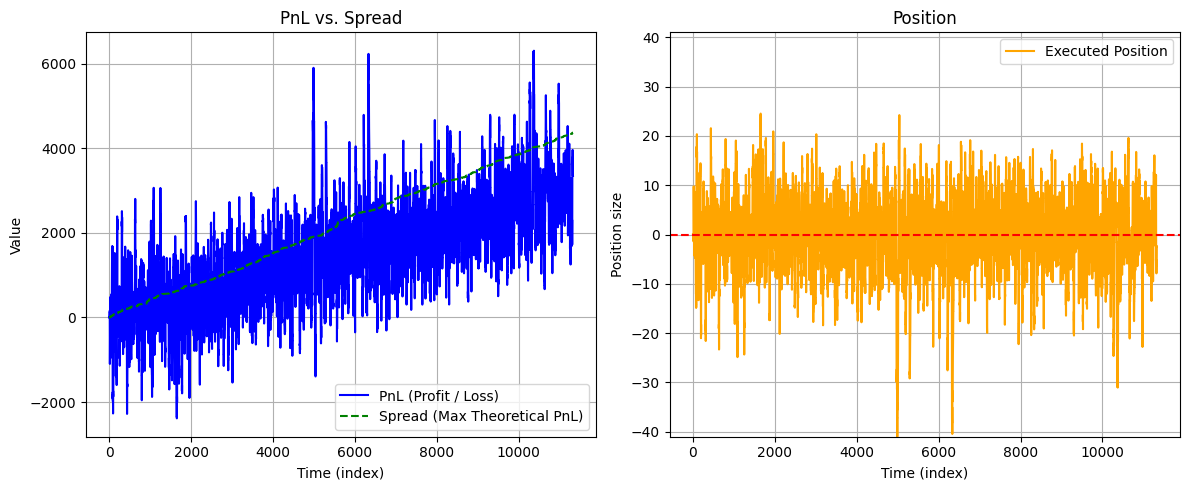

In [19]:
hourly_pnl(big_loader, Price_factor=alpha, Vol_factor=beta, inventory_cap=inv_margin)

Final Inventory: -2.29 | Final PNL: 3418.32
PNL to Spread Ratio: 78.3162%


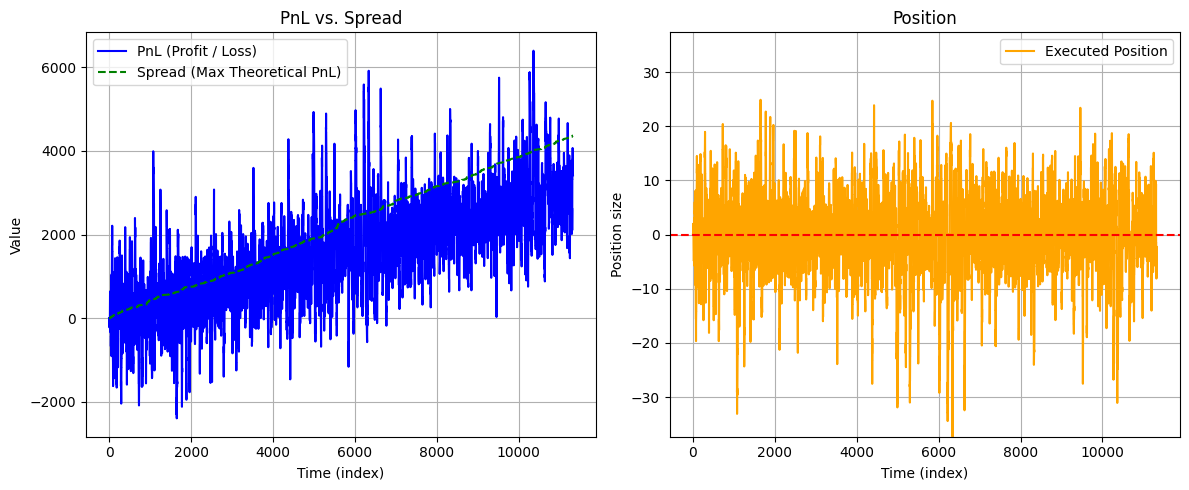

In [20]:
hourly_pnl(big_loader, Price_factor=alpha, Vol_factor=beta, inventory_cap=inv_margin)

Final Inventory: -3.03 | Final PNL: 3409.24
PNL to Spread Ratio: 78.1081%


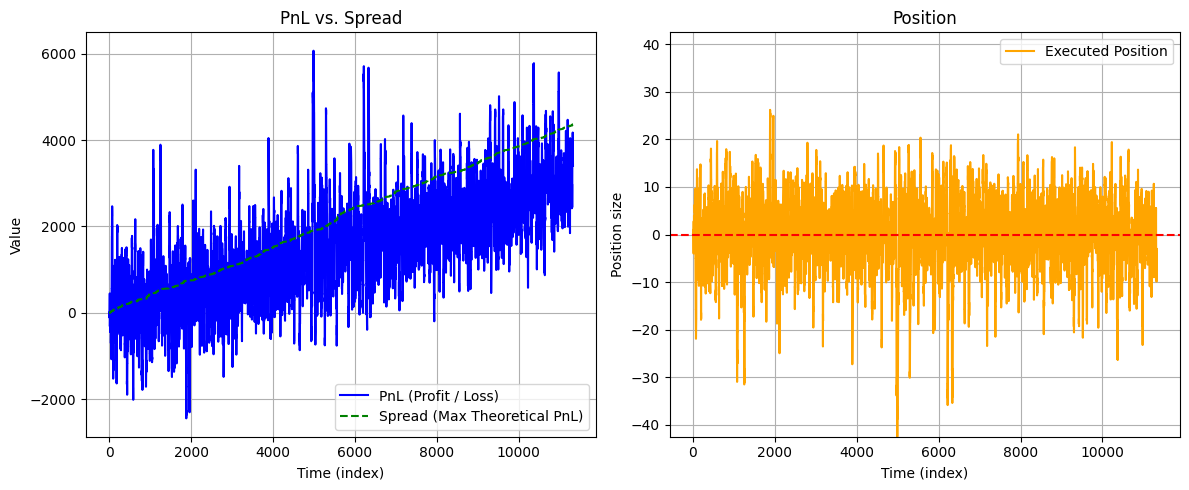

In [21]:
hourly_pnl(big_loader, Price_factor=alpha, Vol_factor=beta, inventory_cap=inv_margin)

## Let's do the same for the next day

In [22]:
path2 = '/content/2025-06-11_BTCUSDT-26SEP25_ob500.data'
loader2 = OrderBookLoader(path2, row_start= 5000, rows_to_process = 20000)
loader2.read_data()

Loading order book : 100%|██████████| 20000/20000 [00:00<00:00, 169054.27it/s]


In [23]:
CT2 = Cold_Tuner(loader2)
study2 = CT2.run_bayesian_tuner()

/usr/local/lib/python3.11/dist-packages/optuna/_experimental.py:32: ExperimentalWarning:

Argument ``multivariate`` is an experimental feature. The interface can change in the future.



  0%|          | 0/1500 [00:00<?, ?it/s]

[Trial 1] Best so far → PnL/Std = 24.7861 | Params = {'alpha': 6, 'beta': 0.9754073832620443, 'inv_margin': 24.134580256934118}
[Trial 51] Best so far → PnL/Std = 60.0043 | Params = {'alpha': 20, 'beta': 0.6953425245586314, 'inv_margin': 10.218535306355681}
[Trial 101] Best so far → PnL/Std = 60.0043 | Params = {'alpha': 20, 'beta': 0.6953425245586314, 'inv_margin': 10.218535306355681}
[Trial 151] Best so far → PnL/Std = 60.0043 | Params = {'alpha': 20, 'beta': 0.6953425245586314, 'inv_margin': 10.218535306355681}
[Trial 201] Best so far → PnL/Std = 60.0043 | Params = {'alpha': 20, 'beta': 0.6953425245586314, 'inv_margin': 10.218535306355681}
[Trial 251] Best so far → PnL/Std = 60.0043 | Params = {'alpha': 20, 'beta': 0.6953425245586314, 'inv_margin': 10.218535306355681}
[Trial 301] Best so far → PnL/Std = 60.0043 | Params = {'alpha': 20, 'beta': 0.6953425245586314, 'inv_margin': 10.218535306355681}
[Trial 351] Best so far → PnL/Std = 90.7943 | Params = {'alpha': 16, 'beta': 0.93703564

In [24]:
vis.plot_optimization_history(study2)

In [47]:
vis.plot_param_importances(study2)

In [25]:
# Load JSON from file
with open("config/best_params.json", "r") as f:
    params = ujson.load(f)

# Access individual parameters
alpha      = params["alpha"]
beta       = params["beta"]
inv_margin = params["inv_margin"]

print(f"Loaded parameters: alpha={alpha}, beta={beta}, inv_margin={inv_margin}")

Loaded parameters: alpha=15, beta=0.6740485010170044, inv_margin=3.0834716202333565


In [26]:
big_loader2 = OrderBookLoader(path2, row_start= 25000, rows_to_process = 50000)
big_loader2.read_data()

Loading order book : 100%|██████████| 50000/50000 [00:00<00:00, 115357.12it/s]


Final Inventory: -2.19 | Final PNL: 3239.77
PNL to Spread Ratio: 83.4013%


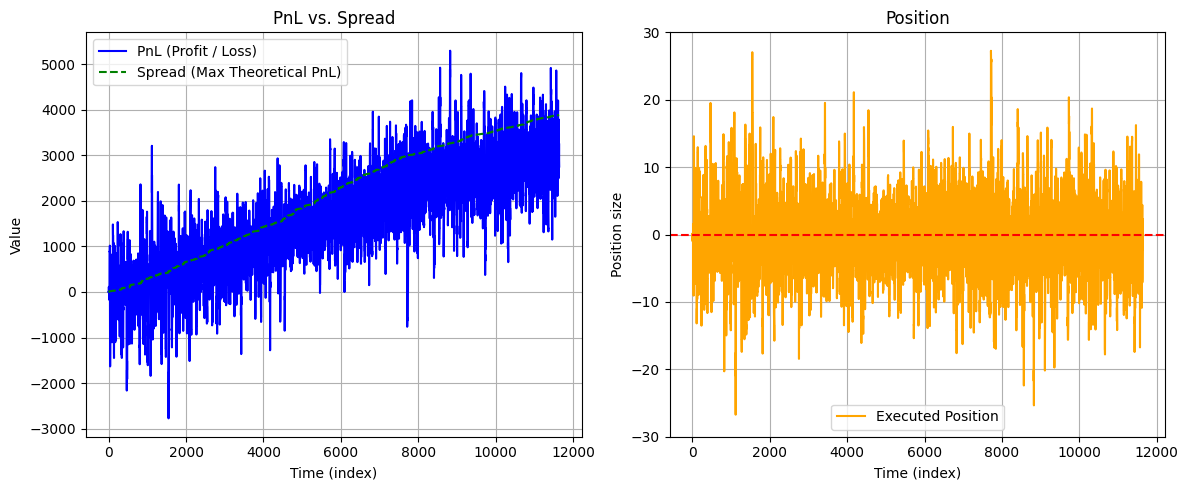

In [27]:
hourly_pnl(big_loader2, Price_factor=alpha, Vol_factor=beta, inventory_cap=inv_margin)

Final Inventory: -1.3 | Final PNL: 3107.17
PNL to Spread Ratio: 79.9876%


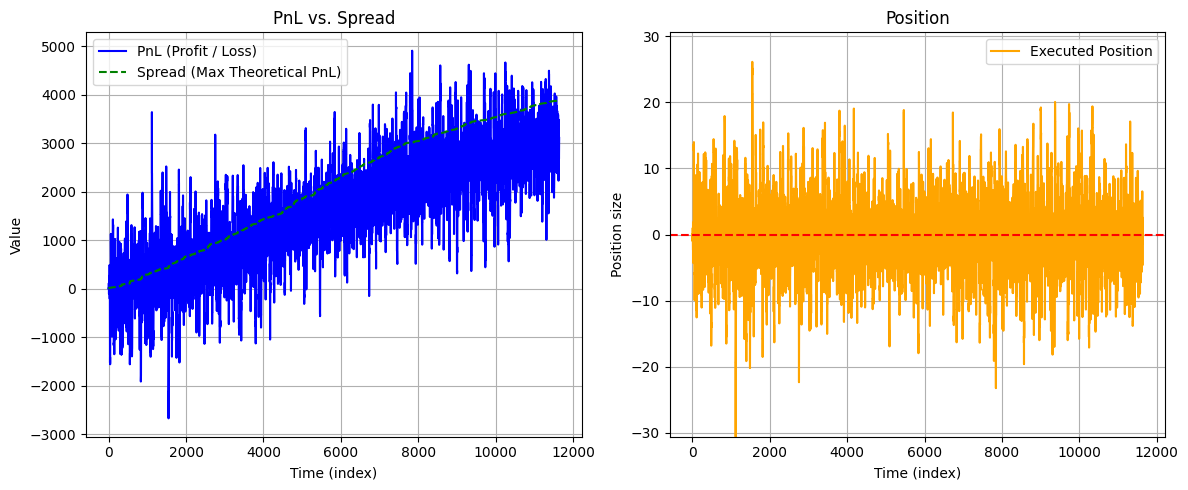

In [28]:
hourly_pnl(big_loader2, Price_factor=alpha, Vol_factor=beta, inventory_cap=inv_margin)

Final Inventory: -1.16 | Final PNL: 3110.08
PNL to Spread Ratio: 80.0627%


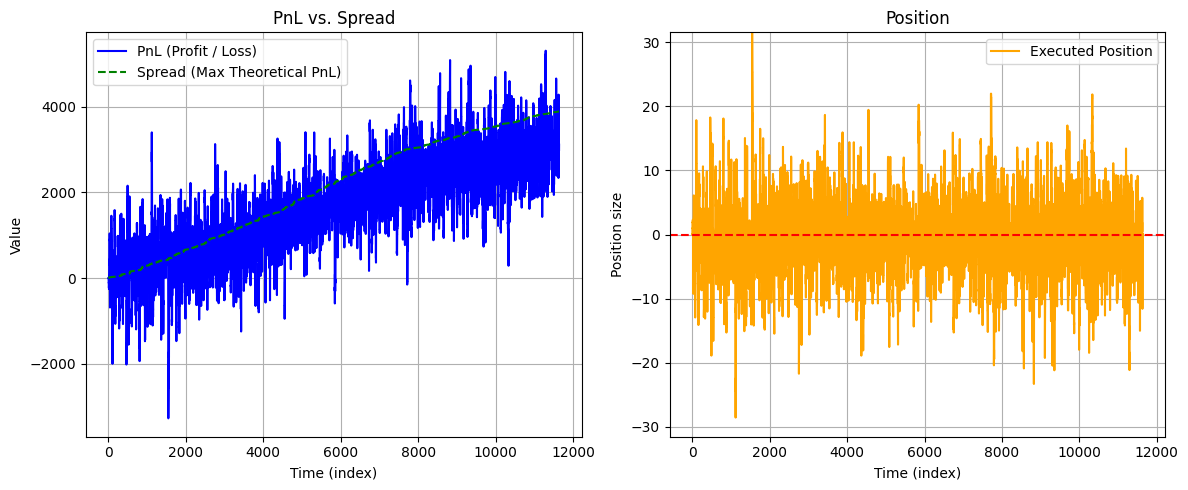

In [29]:
hourly_pnl(big_loader2, Price_factor=alpha, Vol_factor=beta, inventory_cap=inv_margin)

Splendid Results !

## Day after the next day

In [39]:
path3 = '/content/2025-06-12_BTCUSDT-26SEP25_ob500.data'
loader3 = OrderBookLoader(path3, row_start= 10000, rows_to_process = 10000)
loader3.read_data()

Loading order book : 100%|██████████| 10000/10000 [00:00<00:00, 136220.72it/s]


In [61]:
CT3 = Cold_Tuner(loader3)
study3 = CT3.run_bayesian_tuner(n_startup=50)

/usr/local/lib/python3.11/dist-packages/optuna/_experimental.py:32: ExperimentalWarning:

Argument ``multivariate`` is an experimental feature. The interface can change in the future.



  0%|          | 0/1500 [00:00<?, ?it/s]

[Trial 1] Best so far → PnL/Std = 41.9631 | Params = {'alpha': 17, 'beta': 0.05236793244939738, 'inv_margin': 9.196390448134686}
[Trial 51] Best so far → PnL/Std = 52.8429 | Params = {'alpha': 1, 'beta': 0.7700060182630799, 'inv_margin': 12.414512215239723}
[Trial 101] Best so far → PnL/Std = 95.2098 | Params = {'alpha': 1, 'beta': 0.9014597190180086, 'inv_margin': 9.168086218034446}
[Trial 151] Best so far → PnL/Std = 153.3360 | Params = {'alpha': 1, 'beta': 0.0014323033970465998, 'inv_margin': 9.186291169176673}
[Trial 201] Best so far → PnL/Std = 153.3360 | Params = {'alpha': 1, 'beta': 0.0014323033970465998, 'inv_margin': 9.186291169176673}
[Trial 251] Best so far → PnL/Std = 153.3360 | Params = {'alpha': 1, 'beta': 0.0014323033970465998, 'inv_margin': 9.186291169176673}
[Trial 301] Best so far → PnL/Std = 160.7196 | Params = {'alpha': 1, 'beta': 0.0020270295872083077, 'inv_margin': 21.888539725951116}
[Trial 351] Best so far → PnL/Std = 160.7196 | Params = {'alpha': 1, 'beta': 0.0

In [62]:
vis.plot_optimization_history(study3)

In [63]:
vis.plot_param_importances(study3)

In [64]:
# Load JSON from file
with open("config/best_params.json", "r") as f:
    params = ujson.load(f)

# Access individual parameters
alpha      = params["alpha"]
beta       = params["beta"]
inv_margin = params["inv_margin"]

print(f"Loaded parameters: alpha={alpha}, beta={beta}, inv_margin={inv_margin}")

Loaded parameters: alpha=1, beta=0.006890924636580233, inv_margin=11.436293484802901


In [65]:
big_loader3 = OrderBookLoader(path3, row_start= 20000, rows_to_process = 50000)
big_loader3.read_data()

Loading order book : 100%|██████████| 50000/50000 [00:00<00:00, 125954.09it/s]


Final Inventory: -4.76 | Final PNL: 2679.91
PNL to Spread Ratio: 80.8620%


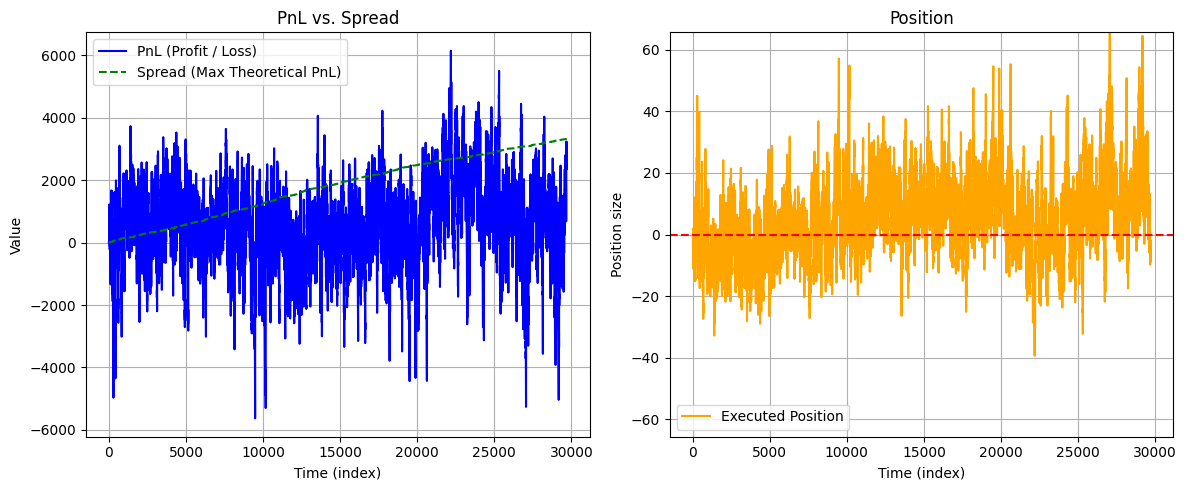

In [69]:
hourly_pnl(big_loader3, Price_factor=alpha, Vol_factor=beta, inventory_cap=inv_margin)

Final Inventory: -9.78 | Final PNL: 3222.19
PNL to Spread Ratio: 97.2244%


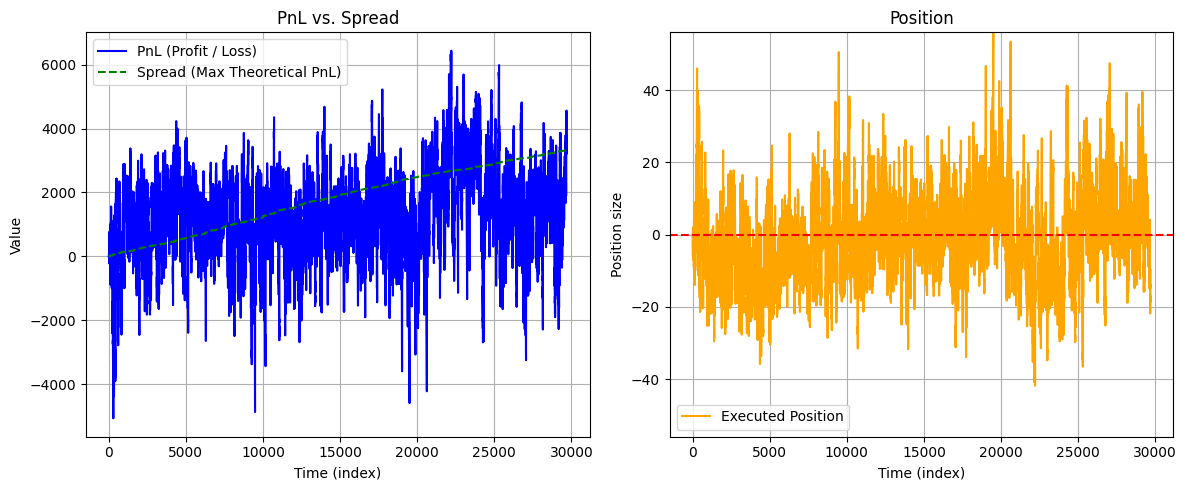

In [67]:
hourly_pnl(big_loader3, Price_factor=alpha, Vol_factor=beta, inventory_cap=inv_margin)

Final Inventory: -8.37 | Final PNL: 3069.43
PNL to Spread Ratio: 92.6152%


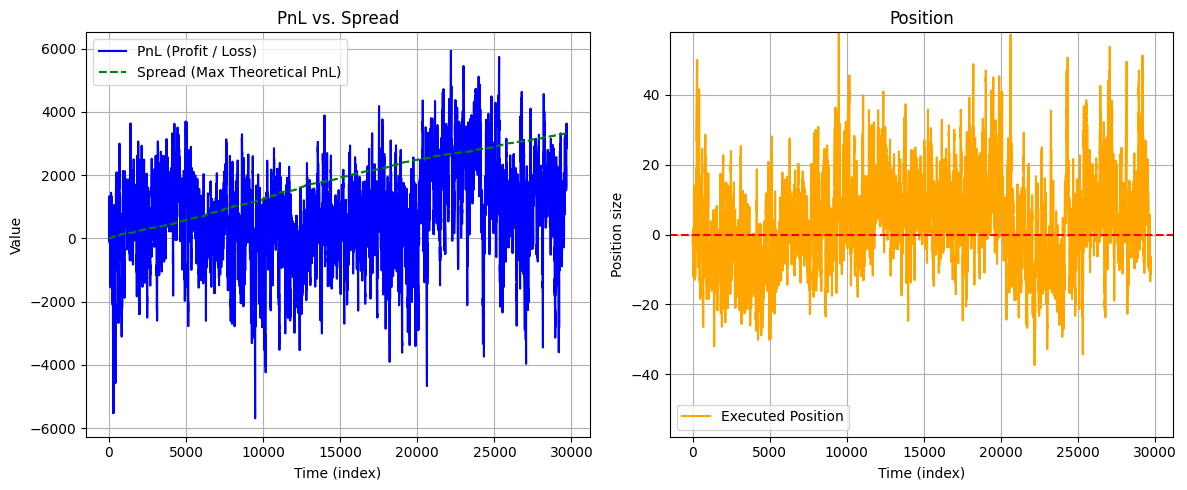

In [68]:
hourly_pnl(big_loader3, Price_factor=alpha, Vol_factor=beta, inventory_cap=inv_margin)